# Confesor Capstone -  MLP Classifer with K.brevis HABs (2023)
## This Jupyter Notebook takes available K.brevis HAB data from the WFS (FWRI & CMEMs), combines them, and predicts the classification of blooms in another dataset.

### Import Packages - Using Python Version 3.11.2 (make sure ConfesorCapstoneEv is set as current kernel!)

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean as cmo
import gsw
import csv

#Opening nc files
import xarray as xr
import os
import string

#Graphing & NetCDF4 FIles
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader
from matplotlib import rcParams, rc
from matplotlib import gridspec
import string

# Model packages
from numpy.random import seed
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from scipy import interpolate
#Train test splitting of data package
from sklearn.model_selection import train_test_split

#Keep figures inline
%matplotlib inline

### Functions to download, sort, and clean necessary files
#### (I'm having a hard time translating these to .py files, leaving them in cells for now)
#### Identifying Blooms as cell counts > 100.
#### We are only looking at shallow water stations (depth < 0.51 m) as well.
#### CMEM & FWRI data only overlap during 2015-2020, so need to subset data

In [2]:
# Downloading CSV function
def DownloadCSV(file,data):
    data=pd.read_csv(file, sep= ',', low_memory=False)
    return(data)

In [3]:
# Bloom Classification function (0=no bloom, 1=bloom)
def BloomClassification(data):
    if data.Kbrevis < 100:
        val = 0
    elif data.Kbrevis > 100:
        val = 1
    return val

In [4]:
# Define Variable Function for csv file
def VariableCSV(file,v,name):
    name=file[v]
    return(name)

In [5]:
# Variable to Array Function
def Array(name,variable):
    name=np.array(variable)
    return(name)

In [6]:
# Saving to CSV file Function
def SaveCSV(file,name):
    file.to_csv(name,sep=',')

In [7]:
# Downloading nc file Function
def DownloadNETCDF(file,data):
    data= xr.open_dataset(file)
    return(data)

In [8]:
# Match FWRI data to CMEMs function (approximation with method=nearest) 
def Matchup(newname,df,a,b,c,d):
    newname=df.sel(longitude=a,latitude=b,time=c,depth=d,method='nearest')
    return(newname)

In [9]:
def VariableNETCDF(file,v,name):
    name=file.variables[v][:]
    return(name)

In [10]:
def NETCDFtoDataframe(Array,Count,Variable,i,df,a,name,Name):
    Array = []                                                                                         
    for i in range(Count): 
        Array.append((np.array(Variable[i,i,i,i].values), np.float32))

    df=pd.DataFrame(Array, columns=[[a],'Type']) 
    name=df[a]
    Name=pd.DataFrame(name)
    return(Name)

In [11]:
#Replace NaN with CMEM Function
def Replace(dataframe,v1,CMEM,v2):
    dataframe[v1] = dataframe[v1].fillna(CMEM[v2])
    dataframe[v1] = dataframe[v1].astype(float)
    return(dataframe[v1])

In [12]:
def NETCDFtoDataframe(Array,Count,Variable,df,a,b,name,Name):
    Array = []                                                                                         
    for i in range(Count): 
        Array.append((np.array(Variable[i,i,i,i].values), np.float32))

    df=pd.DataFrame(Array, columns=[a,b]) 
    name=df[a]
    Name=pd.DataFrame(name)
    return(Name)

In [13]:
#Add Nutrient Column Function
def AddNutrient(Dataframe,Name,Variable):
    Dataframe[Name]=Variable
    Dataframe[Name]=Dataframe[Name].astype(float)
    return(Dataframe[Name])

In [14]:
#Drop all NaN rows of combined data and save to csv file
def DropNaN(newdf,olddf,name):
    newdf=olddf.dropna()
    newdf.to_csv(name, sep=',')

### Cleaning the Data

In [15]:
# Download CSV & organize & clean data
Kbrevis_df=DownloadCSV('Kbrevis_Abundance.csv','Kbrevis_df')
Kbrevis_df['BloomID'] = Kbrevis_df.apply(BloomClassification, axis=1)
Kbrevis_df1= Kbrevis_df[Kbrevis_df['Depth_m']<0.51]
Kbrevis_df2= Kbrevis_df1[Kbrevis_df1['Date']<'2021-01-01']

# Save indexed Kbrevis_df data into a new csv file & open it for later
SaveCSV(Kbrevis_df2,'Kb_Indexed.csv')
Kb_df=DownloadCSV('Kb_Indexed.csv','Kb_df')
# Save Date as datetime & remove unnamed column
Kb_df[['Date']] = Kb_df[['Date']].apply(pd.to_datetime)
Kb_df=Kb_df.drop(columns= ['Unnamed: 0'])

Kb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25867 entries, 0 to 25866
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       25867 non-null  datetime64[ns]
 1   Depth_m    25867 non-null  float64       
 2   Latitude   25867 non-null  float64       
 3   Longitude  25867 non-null  float64       
 4   Kbrevis    25867 non-null  int64         
 5   Temp_C     16158 non-null  float64       
 6   Salinity   15047 non-null  float64       
 7   BloomID    25867 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 1.6 MB


In [16]:
#Time, Lat, Lon, and Depth are from Indexed K.brevis in situ data- matching up with CMEMS
Lat=VariableCSV(Kb_df,'Latitude','Lat')
Lon=VariableCSV(Kb_df,'Longitude','Lon')
Time=VariableCSV(Kb_df,'Date','Time')
Depth=VariableCSV(Kb_df,'Depth_m','Depth')
Kbrevis=VariableCSV(Kb_df,'Kbrevis','Kbrevis')

#Turn into Arrays for matchup to work
LatArray=Array('LatArray',Lat)
LonArray=Array('LonArray',Lon)
TimeArray=Array('TimeArray',Time)
DepthArray=Array('DepthArray',Depth)

In [17]:
#Download NetCDF Files, then match up with insitu time, lat,lon, and depth.
SalTemp_df=DownloadNETCDF('SalTempTotal.nc','SalTemp_df')
SalTemp=Matchup('SalTemp',SalTemp_df,LonArray,LatArray,TimeArray,DepthArray)
#SalTemp

Nutrient_df=DownloadNETCDF('NutrientsTotal.nc','SalTemp_df')
Nutrient=Matchup('Nutrient',Nutrient_df,LonArray,LatArray,TimeArray,DepthArray)
Nutrient

#Assign the variables, for indexed NETCDF data
thetao = VariableNETCDF(SalTemp,'thetao','thetao')
so = VariableNETCDF(SalTemp,'so','so')
no3= VariableNETCDF(Nutrient,'no3','no3')
o2 = VariableNETCDF(Nutrient,'o2','o2')
po4 = VariableNETCDF(Nutrient,'po4','po4')
chl = VariableNETCDF(Nutrient,'chl','chl')
si = VariableNETCDF(Nutrient,'si','si')

In [18]:
#Get # of samples (rows)
Count=Kbrevis.count()

#Grab only the variables of interest from indext NETCDF files and put them into a dataframe
CMEMthetao=NETCDFtoDataframe('Thetao',Count,thetao,'Thetao_df','Thetao','Type','arrthetao','CMEMthetao')
CMEMso=NETCDFtoDataframe('So',Count,so,'so_df','So','Type','arrthetao','CMEMso')
CMEMno3=NETCDFtoDataframe('NO3',Count,no3,'no3_df','NO3','Type','arrno3','CMEMno3')
CMEMo2=NETCDFtoDataframe('O2',Count,o2,'o2_df','O2','Type','arro2','CMEMo2')
CMEMpo4=NETCDFtoDataframe('PO4',Count,po4,'po4_df','PO4','Type','arrpo4','CMEMpo4')
CMEMchl=NETCDFtoDataframe('Chl',Count,chl,'chl_df','chl','Type','arrchl','CMEMchl')
CMEMsi=NETCDFtoDataframe('Si',Count,si,'si_df','Si','Type','arrsi','CMEMsi')

In [19]:
#Replace NaN values in insitu data with CMEM data as float variables
Temp=Replace(Kb_df,'Temp_C',CMEMthetao,'Thetao')
Sal=Replace(Kb_df,'Salinity',CMEMso,'So')

#Add Nutrients
NO3=AddNutrient(Kb_df,'NO3',CMEMno3)
O2=AddNutrient(Kb_df,'O2',CMEMo2)
PO4=AddNutrient(Kb_df,'PO4',CMEMpo4)
chl=AddNutrient(Kb_df,'chl',CMEMchl)
si=AddNutrient(Kb_df,'Si',CMEMsi)

#Remove NaN in the entire file, then save to new CSV file
DropNaN('FinalKb_df',Kb_df,'Kb_final.csv')

#what we will be using!
Kb_final=DownloadCSV('Kb_final.csv','Kb_final')

### EDA

In [20]:
Kb_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10064 entries, 0 to 10063
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10064 non-null  int64  
 1   Date        10064 non-null  object 
 2   Depth_m     10064 non-null  float64
 3   Latitude    10064 non-null  float64
 4   Longitude   10064 non-null  float64
 5   Kbrevis     10064 non-null  int64  
 6   Temp_C      10064 non-null  float64
 7   Salinity    10064 non-null  float64
 8   BloomID     10064 non-null  int64  
 9   NO3         10064 non-null  float64
 10  O2          10064 non-null  float64
 11  PO4         10064 non-null  float64
 12  chl         10064 non-null  float64
 13  Si          10064 non-null  float64
dtypes: float64(10), int64(3), object(1)
memory usage: 1.1+ MB


In [21]:
#Define variables
Lon=VariableCSV(Kb_final,'Longitude','Lon')
Lat=VariableCSV(Kb_final,'Latitude','Lat')
Depth=VariableCSV(Kb_final,'Depth_m','Depth')
Kbrevis=VariableCSV(Kb_final,'Kbrevis','Kbrevis')
Temp=VariableCSV(Kb_final,'Temp_C','Temp')
Sal=VariableCSV(Kb_final,'Salinity','sAL')
BloomID=VariableCSV(Kb_final,'BloomID','BloomID')
NO3=VariableCSV(Kb_final,'NO3','NO3')
O2=VariableCSV(Kb_final,'O2','O2')
PO4=VariableCSV(Kb_final,'PO4','PO4')
Chl=VariableCSV(Kb_final,'chl','Chl')
Si=VariableCSV(Kb_final,'Si','Si')

#EDA- PO4 has smallest variance, while Kbrevis has biggest variance
Kb_final[['Kbrevis','Depth_m','Temp_C','Salinity','NO3','O2','PO4','chl','Si']].agg(['std','mean','median','max','min'])


Kbrevis   Depth_m     Temp_C   Salinity        NO3          O2  \
std     1.606814e+06  0.141290   5.028454   6.053556   1.644527   16.726130   
mean    1.299599e+05  0.405495  24.817921  31.900248   1.248983  217.986555   
median  0.000000e+00  0.500000  25.600000  34.363842   0.762936  216.005150   
max     7.729556e+07  0.500000  39.100000  47.290000  11.818180  259.390350   
min     0.000000e+00  0.100000   5.700000   0.150000   0.004355  191.406006   

             PO4       chl         Si  
std     0.003074  0.292880   4.926889  
mean    0.002111  0.414104  10.179175  
median  0.001221  0.310534   9.892280  
max     0.074222  2.188021  24.072092  
min     0.000027  0.073073   2.476244

### Plotting

C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


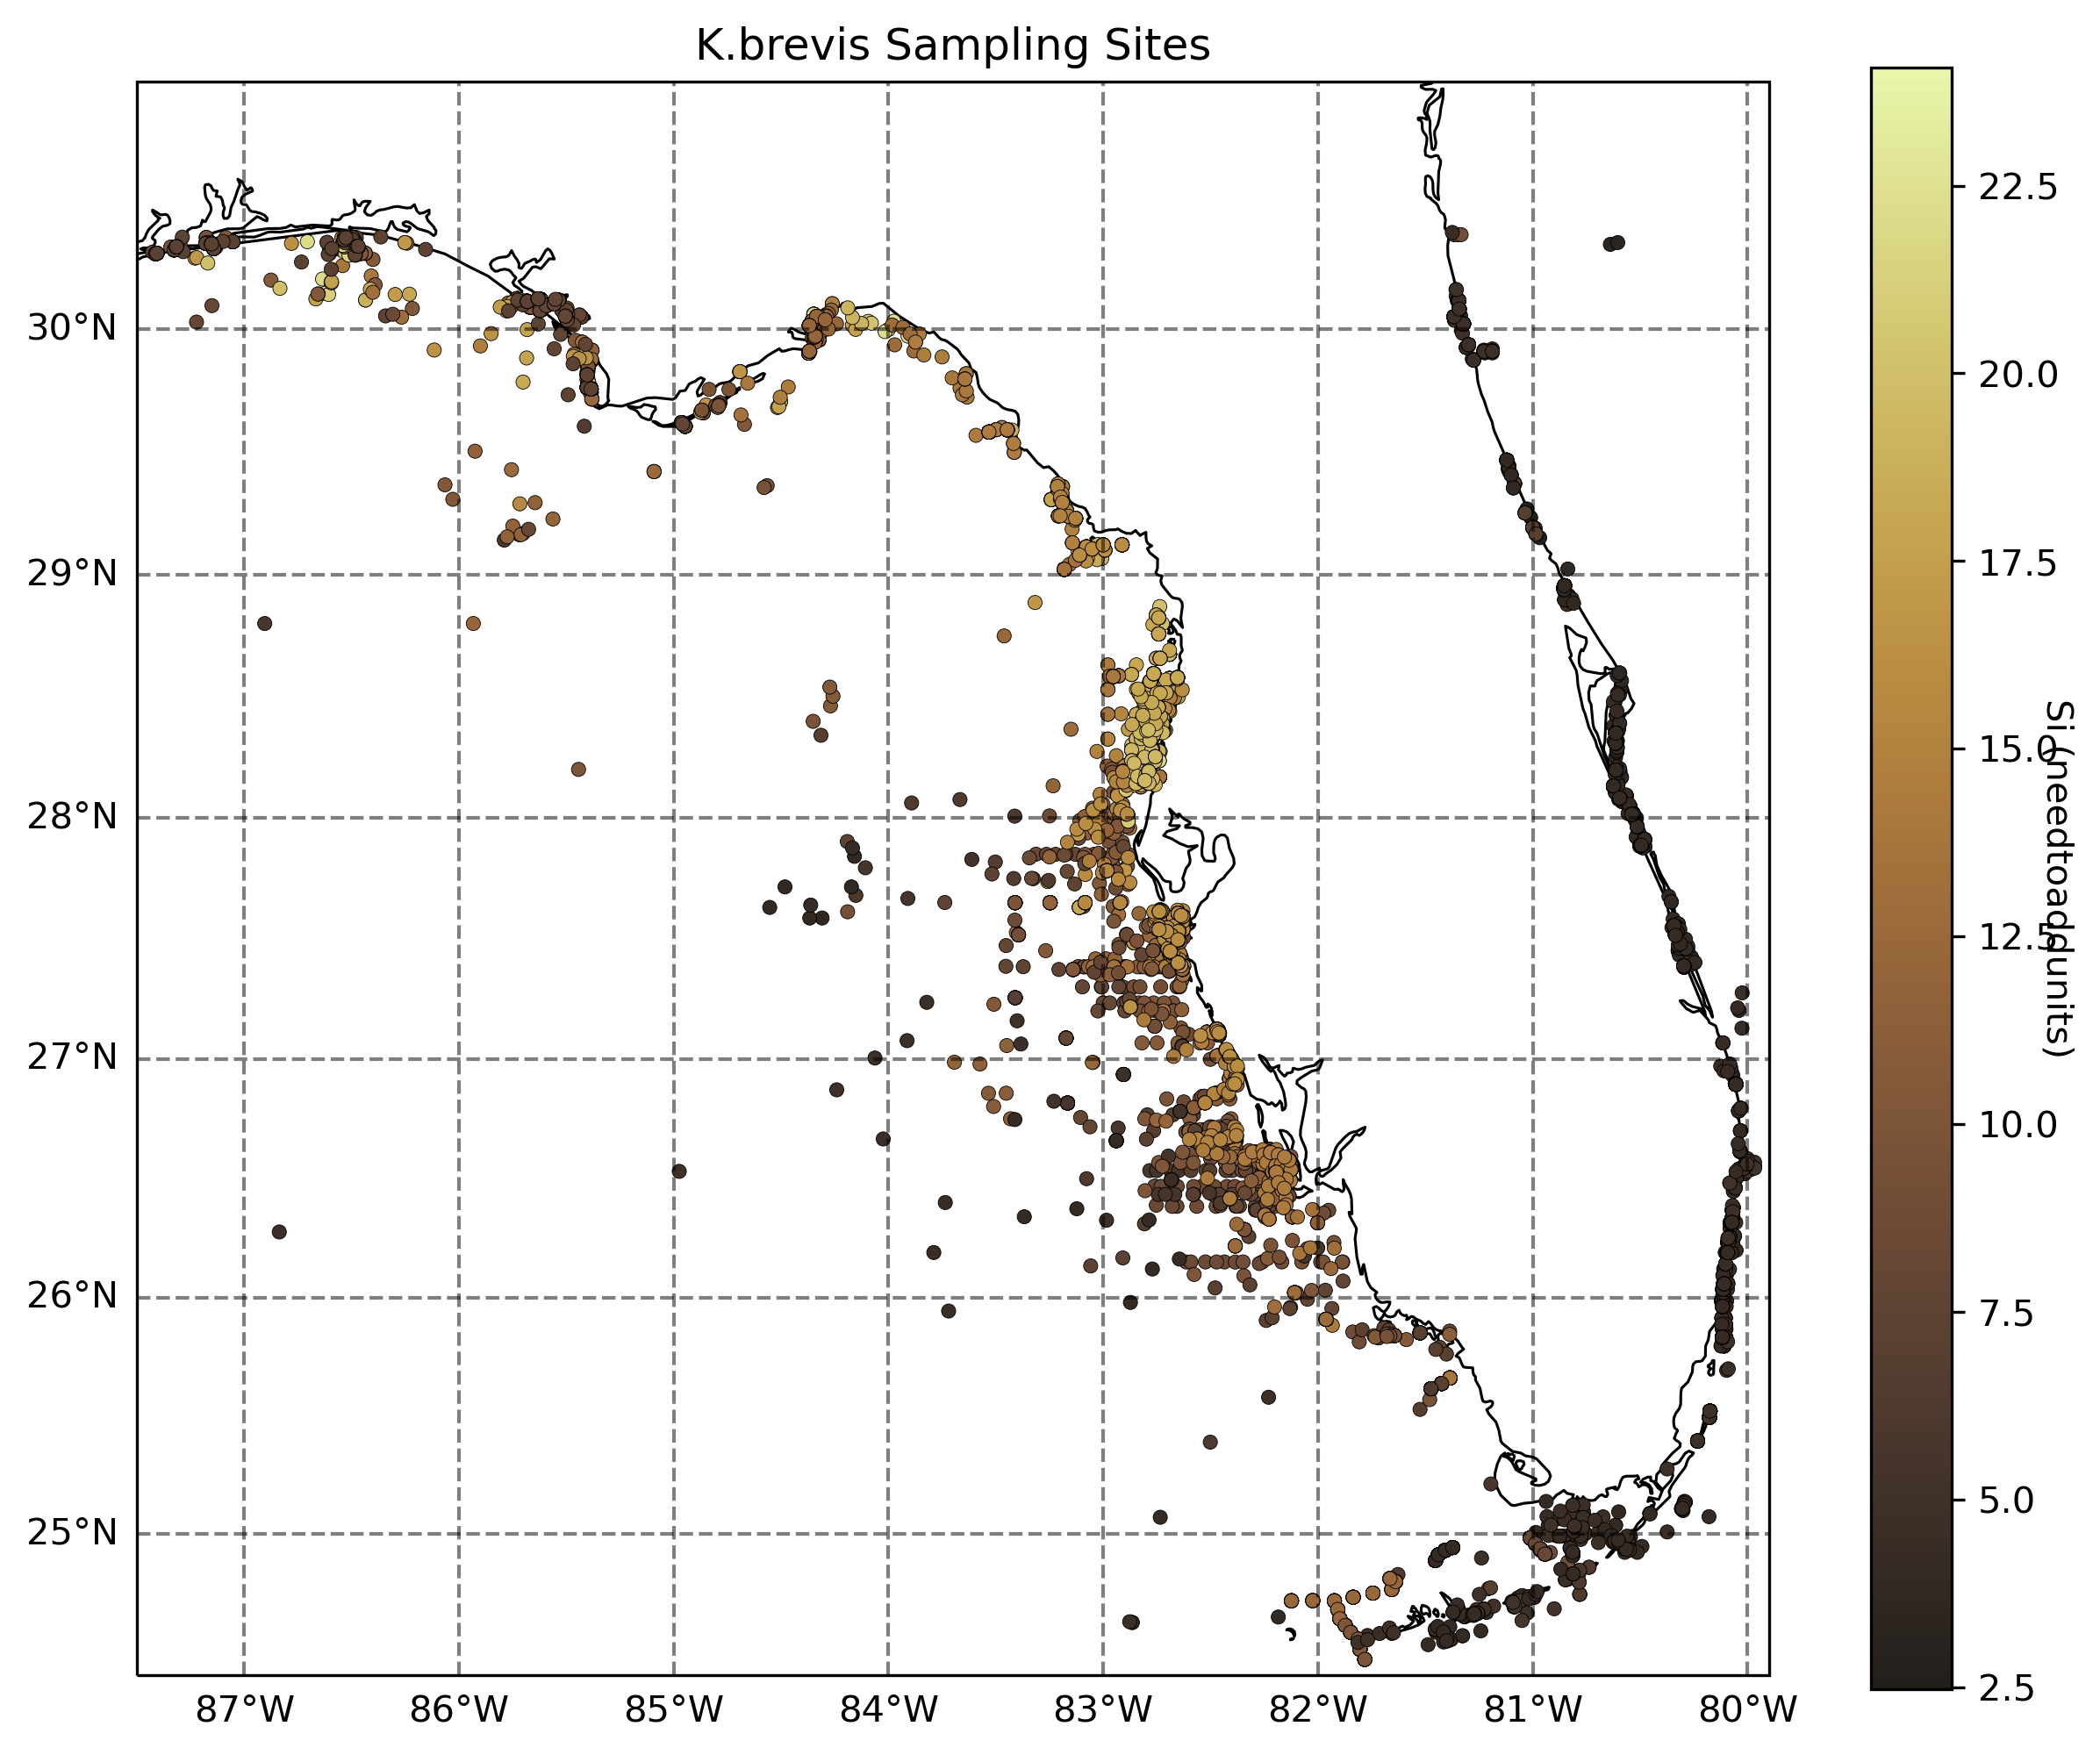

In [22]:
##PLOTTING DATAPOINTS- Will be working on turning this into a function over the weekend

fig = plt.figure(figsize = (10,8), dpi = 300)
ax = fig.add_subplot(1,1,1, projection = ccrs.Mercator(central_longitude = 0.0, min_latitude = 24, max_latitude = 31))

# ax.set_extent(east, west, south, north)
ax.set_extent([-87.5, -79.9, 24.4, 49])
ax.coastlines(linewidth=0.75, color='black',zorder=0)
ax.set_title('K.brevis Sampling Sites')#, color = 'red', weight = 'bold')
nn = ax.scatter(Lon, Lat,s=15,c=Si,cmap = cmo.cm.turbid_r,vmin=Si.min(), vmax=Si.max(),zorder=1,edgecolors='black',linewidths=0.2,
           transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k',linestyle='--',alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar=plt.colorbar(nn)
cbar.ax.set_ylabel('Si (needtoaddunits)', rotation=270)

plt.show()
#plt.savefig('KbrevisSamplingSi.png',format='png',dpi=600,transparent=False)

### TS- Diagram

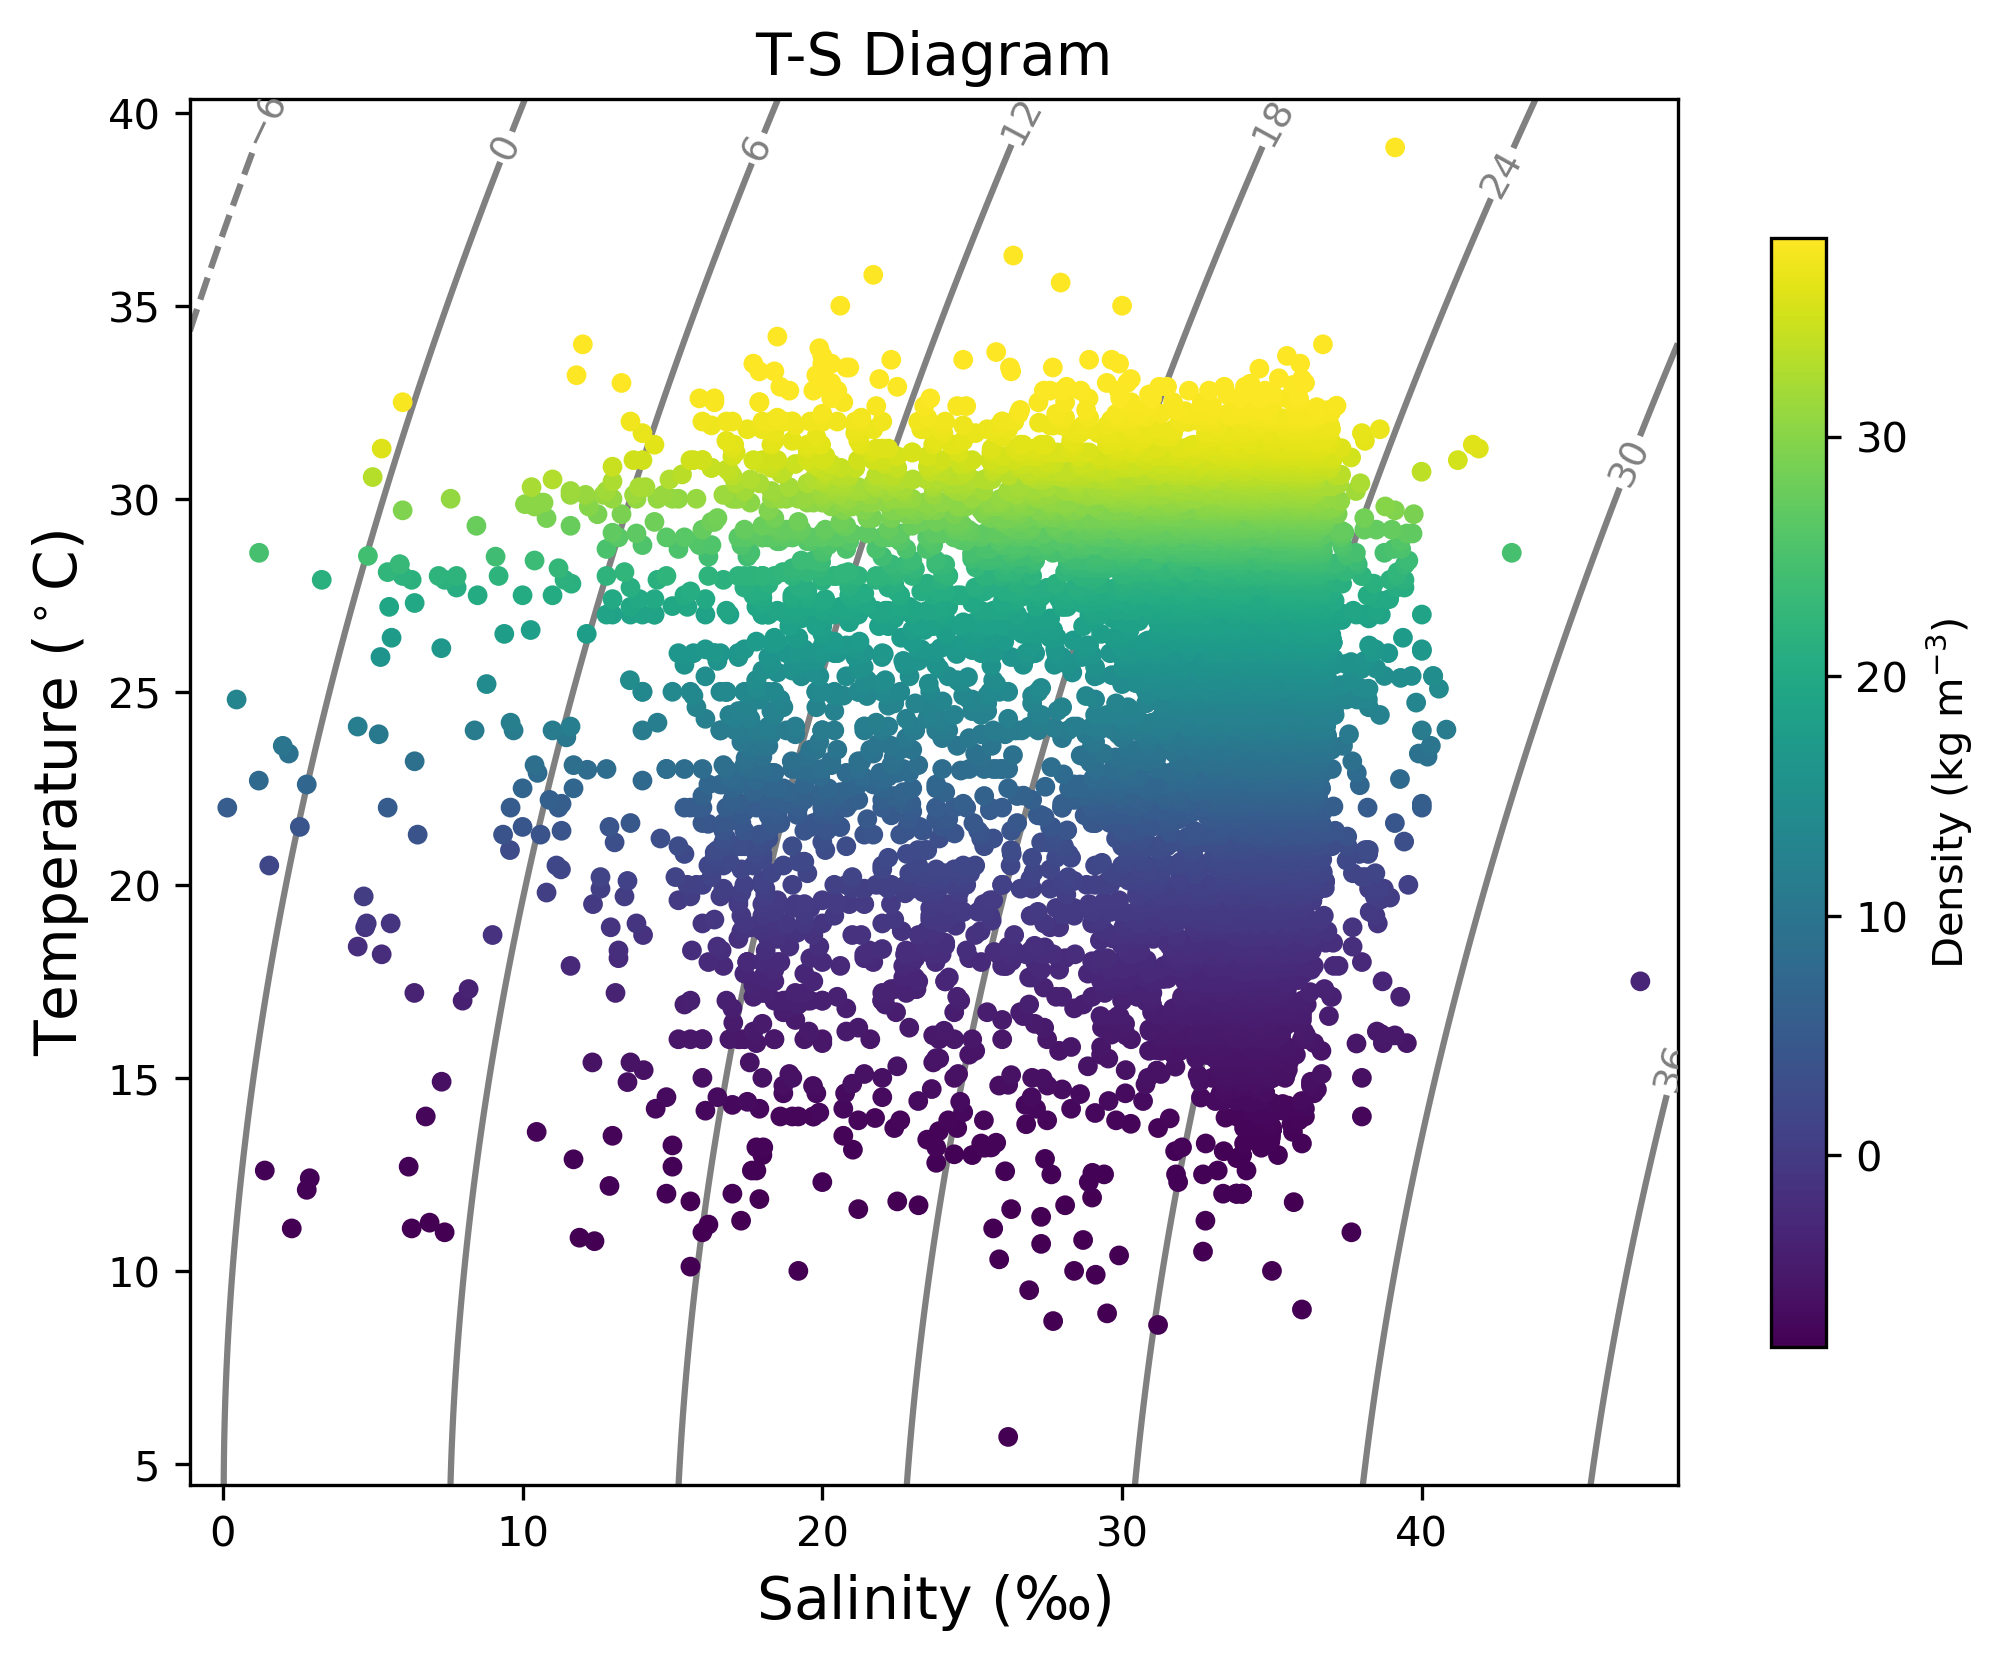

In [23]:
#TS Diagram-working on turning this into a function this weekend
TS=Kb_final[['Temp_C', 'Salinity']]

TS_df=TS.sort_values('Temp_C',ascending=True)

mint=np.min(TS_df['Temp_C'])
maxt=np.max(TS_df['Temp_C'])

mins=np.min(TS_df['Salinity'])
maxs=np.max(TS_df['Salinity'])

tempL=np.linspace(mint-1.25, maxt+1.25,10064)

salL=np.linspace(mins-1.25,maxs+1.25,10064)

Tg, Sg = np.meshgrid(tempL,salL)
sigmatheta = gsw.sigma0(Sg,Tg)
cnt = np.linspace(sigmatheta.min(), sigmatheta.max(),10064)

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
cs = ax.contour(Sg, Tg, sigmatheta, colors='grey', zorder=1)

#manual_locations = [(-60, 70)]
cl=plt.clabel(cs,fontsize=9,inline=True)

sc=plt.scatter(TS_df['Salinity'], TS_df['Temp_C'],c=cnt,s=14)

cb=plt.colorbar(sc,shrink=0.8)

ax.set_xlabel('Salinity ($‰$)',fontsize=14)

ax.set_ylabel('Temperature ($^\circ$C)',fontsize=14)

ax.set_title('T-S Diagram',fontsize=14)

ax.tick_params(direction='out')
cb.ax.tick_params(direction='out')
cb.set_label('Density (kg m$^{-3}$)')
#plt.tight_layout()
#plt.savefig(‘TS.png’,format=’png’,dpi=600,transparent=False)
plt.show()

### Spearman Correlations (working on turning this into a funtion)

In [24]:
rho1,p1 = spearmanr(Kbrevis, Depth,alternative='two-sided')
rho2,p2 = spearmanr(Kbrevis, Sal,alternative='two-sided')
rho3,p3 = spearmanr(Kbrevis, Temp,alternative='two-sided')
rho4,p4 = spearmanr(Kbrevis, NO3,alternative='two-sided')
rho5,p5 = spearmanr(Kbrevis, O2,alternative='two-sided')
rho6,p6 = spearmanr(Kbrevis, PO4,alternative='two-sided')
rho7,p7 = spearmanr(Kbrevis, Chl,alternative='two-sided')
rho8,p8 = spearmanr(Kbrevis, Si,alternative='two-sided')

Value={'Test':['Kbrevis vs Depth','Kbrevis vs Sal','Kbrevis vs Temp','Kbrevis vs NO3',
              'Kbrevis vs O2','Kbrevis vs PO4','Kbrevis vs Chl','Kbrevis vs Si'], 
       'Rho':[rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8], 'P-value':[p1,p2,p3,p4,p5,p6,p7,p8],
       'Significant':['Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes']}
SpearmanTestResult=pd.DataFrame(Value)
SpearmanTestResult

Test       Rho       P-value Significant
0  Kbrevis vs Depth  0.059603  2.178398e-09         Yes
1    Kbrevis vs Sal  0.067445  1.262214e-11         Yes
2   Kbrevis vs Temp -0.061056  8.786673e-10         Yes
3    Kbrevis vs NO3  0.128968  1.381598e-38         Yes
4     Kbrevis vs O2  0.084421  2.192076e-17         Yes
5    Kbrevis vs PO4  0.021748  2.913160e-02         Yes
6    Kbrevis vs Chl  0.048837  9.505035e-07         Yes
7     Kbrevis vs Si  0.167928  1.492788e-64         Yes

### MLP Classifier (split into train & test sets,figure out best layer/node combo & predict other datasets)

In [25]:
# Feature matrix in a object named X
x=Kb_final.drop(columns= ['BloomID','Unnamed: 0','Date','Latitude','Longitude'])
# response vector in a object named y
y = Kb_final.BloomID

label = eval('["No Bloom", "Bloom"]')
print (label)
x

['No Bloom', 'Bloom']


Depth_m  Kbrevis     Temp_C   Salinity       NO3          O2       PO4  \
0          0.5        0  17.300000  34.240000  1.959385  239.028183  0.002489   
1          0.5        0  17.200000  30.500000  1.959385  239.028183  0.002489   
2          0.5        0  17.600000  32.720000  1.959385  239.028183  0.002489   
3          0.5        0  17.400000  34.770000  1.959385  239.028183  0.002489   
4          0.5        0  17.100000  34.680000  1.959385  239.028183  0.002489   
...        ...      ...        ...        ...       ...         ...       ...   
10059      0.5        0  20.500000   1.550000  0.020753  219.038513  0.004036   
10060      0.5    26000  21.280000  36.400000  0.982610  234.005066  0.002495   
10061      0.5  1891391  21.830000  35.720000  0.866491  233.072983  0.002416   
10062      0.5        0  13.708517  34.681232  2.500659  249.603653  0.003386   
10063      0.5        0  13.819117  34.917751  2.500659  249.603653  0.003386   

            chl         Si  
0      0.674253  11.138027  
1      0.674253  11.138027  
2      0.674253  11.138027  
3      0.674253  11.138027  
4      0.674253  11.138027  
...         ...        ...  
10059  0.564759   3.892709  
10060  0.625223  14.416743  
10061  0.607294  14.053338  
10062  0.890501  14.317658  
10063  0.890501  14.317658  

[10064 rows x 9 columns]

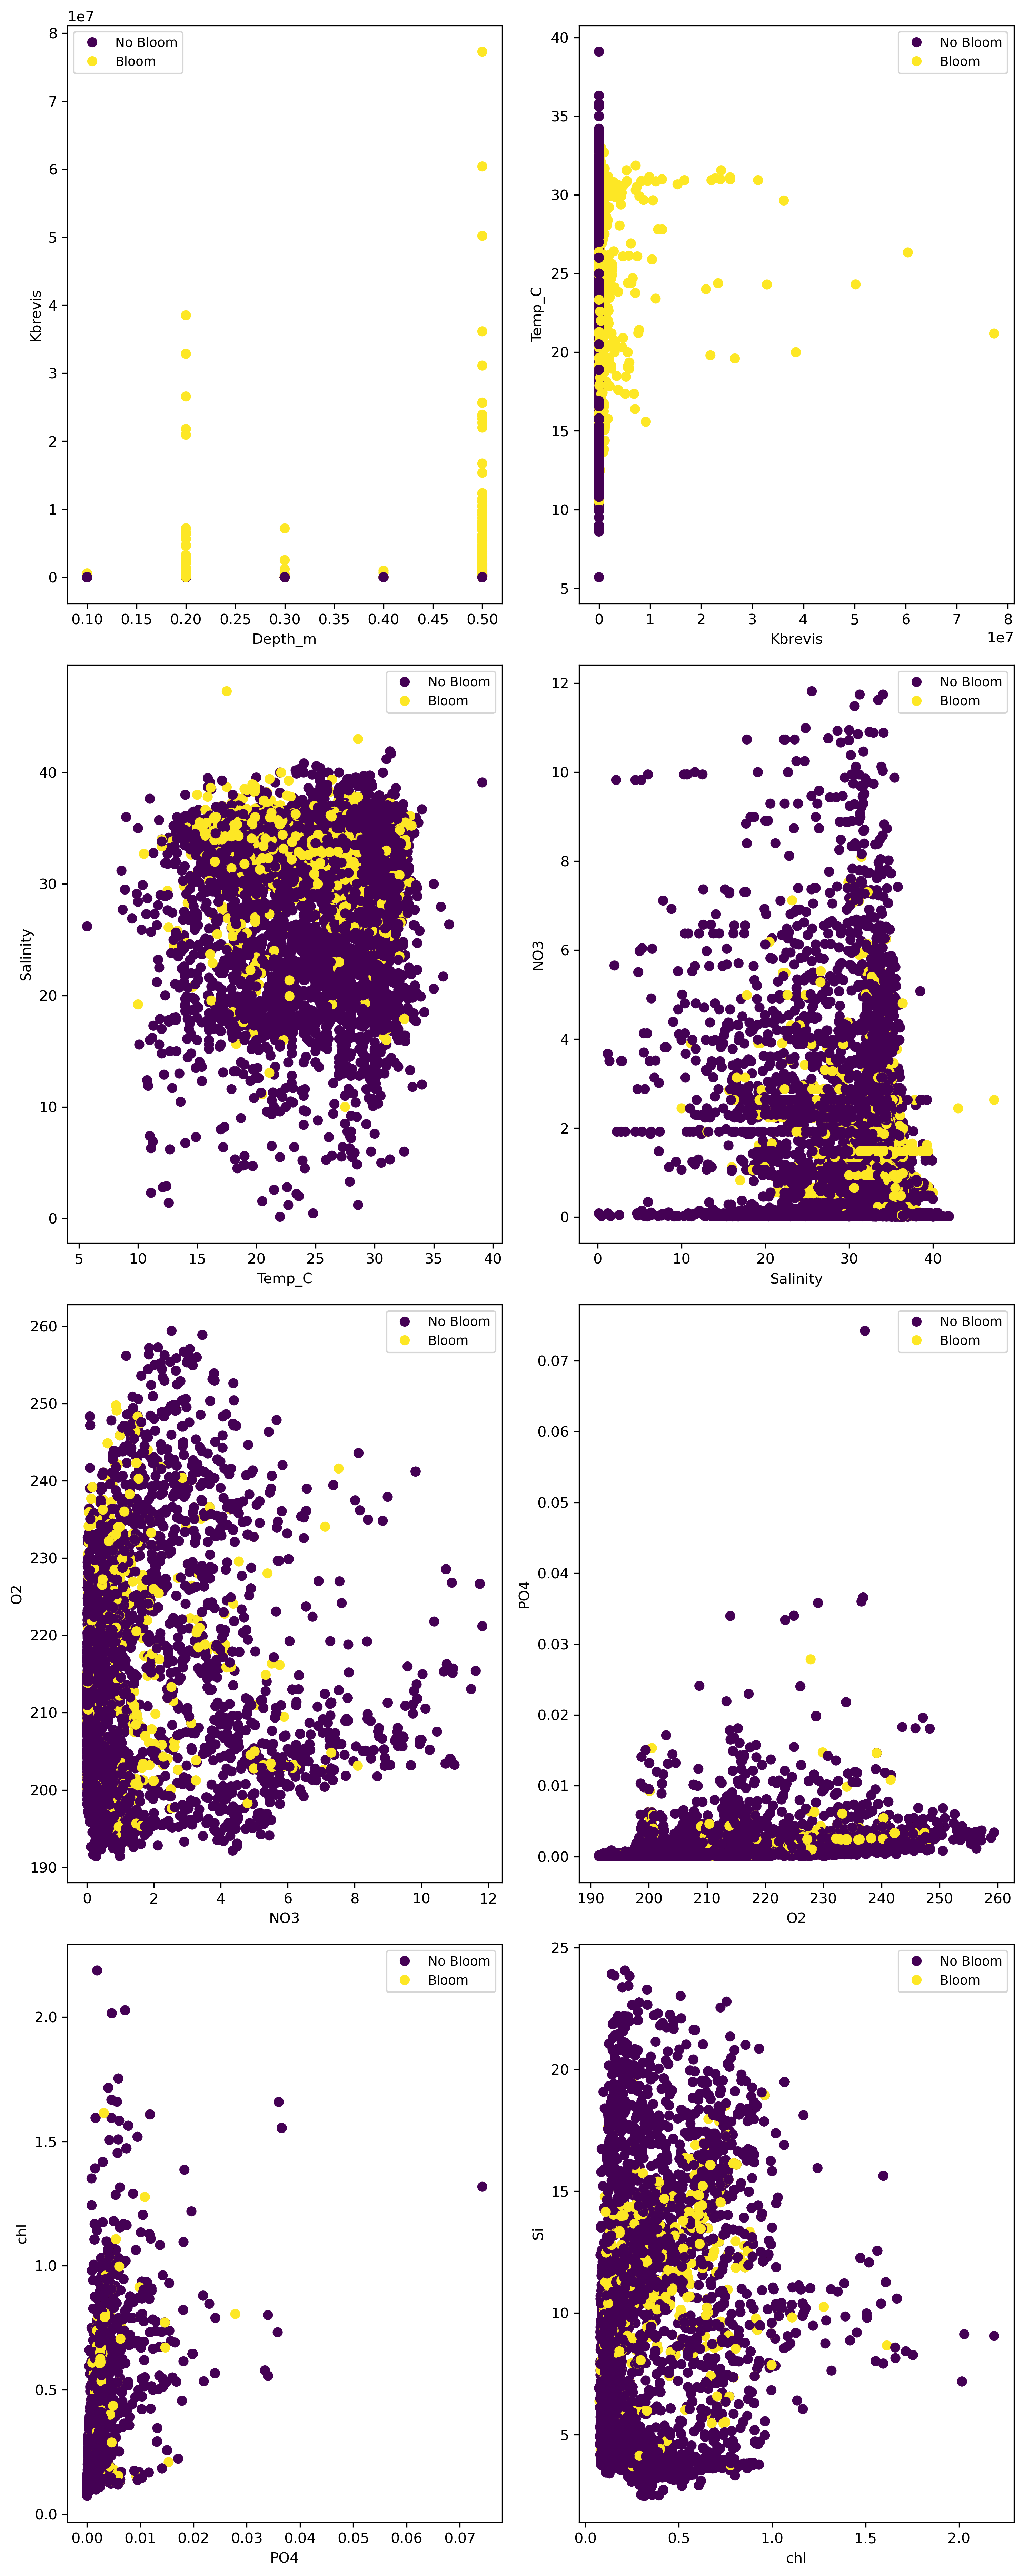

In [26]:
nrows, ncols = 4, 2 #set 4 rows and 2 column
fig = plt.figure(figsize = (10,25), dpi = 300)

for i in range(1, 9): #i will iterate from 1 through 9
    ax = fig.add_subplot(nrows, ncols, i) #add subplot one at a time (#rows and columns, i is the position)
    PltScat=ax.scatter(x.iloc[:,i-1], x.iloc[:,i],c=y) #based on number of the column iloc is index location i-1 (starting point @ 0), i
    Label=label
    ax.legend(PltScat.legend_elements()[0],Label,prop = {'size' : 9})
    ax.set_xlabel(x.columns[i-1])
    ax.set_ylabel(x.columns[i])
plt.tight_layout()
plt.show()

[1]
MLPClassifier(hidden_layer_sizes=array([50], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([51], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([52], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([53], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([54], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([55], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([56], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([57], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([58], dtype=int8), max_iter=2500,
              random_state=1)
MLPClassifier(hidden_layer_sizes=array([59], dtype=int8), max_iter=25

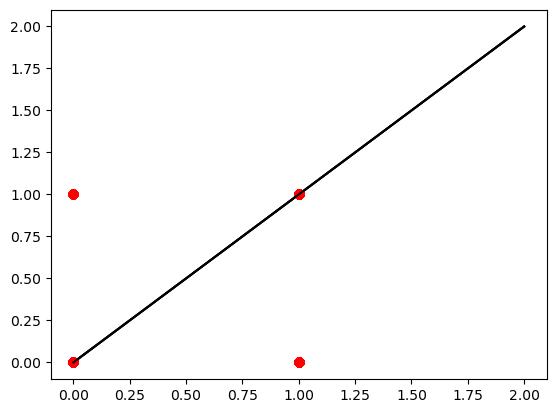

In [27]:
## MODEL CONSTRUCTION

# Split data in train and test data (80:20)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scores = {}
scores_list = []

#build a nested loop to loop through both various numbers of layers and nodes
l_range = range(1,4,1)
n = range(50,63,1)

for l in l_range:
    layers = np.ones(l, dtype=np.int8) #create an array of ones that loops with l
    print(layers)
    
    for i in n:
        mlp = MLPClassifier(hidden_layer_sizes=(i*layers), max_iter=2500, random_state=1) 
        print(mlp)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    scores[l] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    plt.plot(y_test, y_pred, 'ro')
    plt.plot([0, 2], [0, 2],'k')
#confusion matrix to determine the accuracy ( total # of correct predictions / by the total # of all predictions)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

Text(0.5, 1.0, 'Model Accuracy for k (hidden layer sizes)')

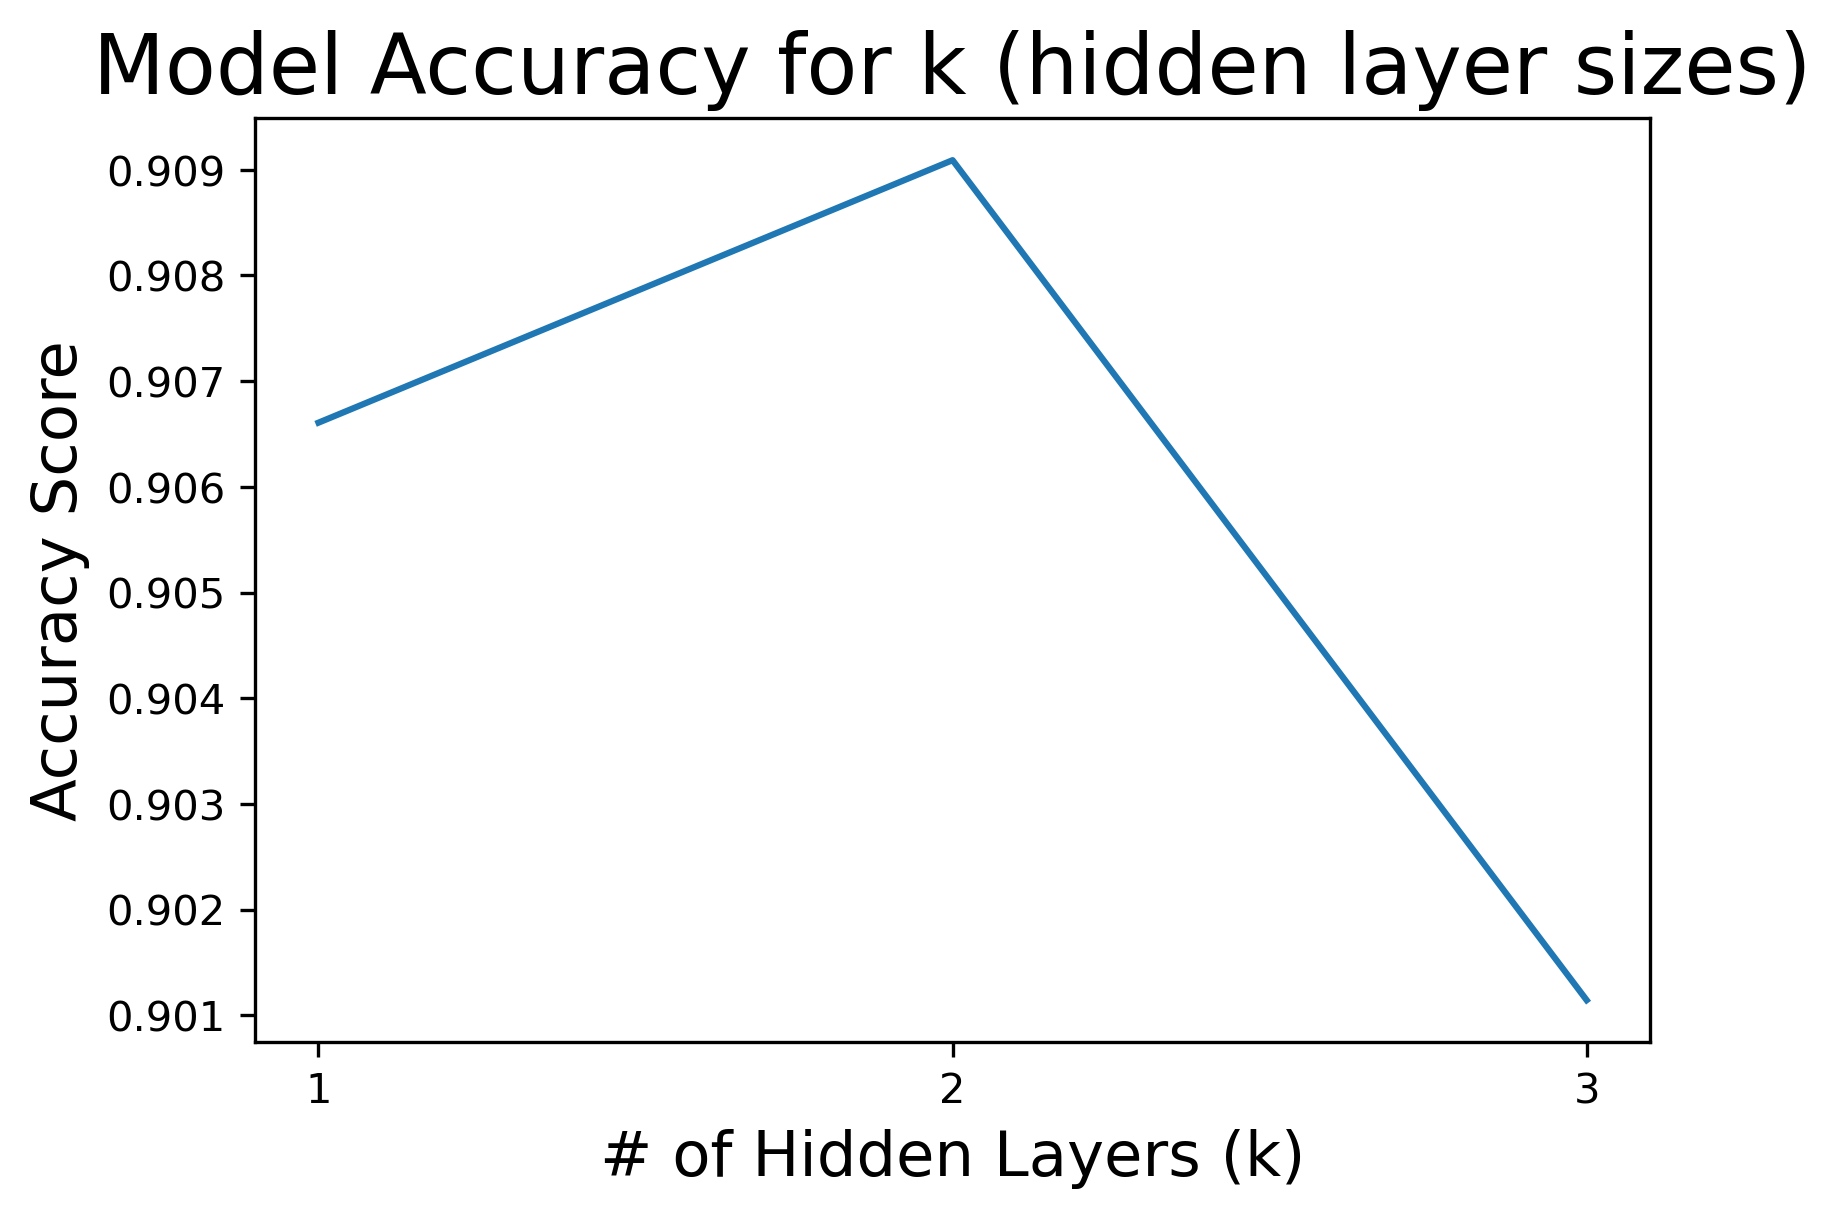

In [28]:
# plot the model accuracy for each value of k
Fig1= plt.figure(figsize = (6,4), dpi = 300)
plt.plot(l_range,scores_list)
plt.xticks(np.arange(min(l_range), max(l_range)+1, 1.0))
plt.xlabel('# of Hidden Layers (k)',size=15)
plt.ylabel('Accuracy Score',size=15)
plt.title('Model Accuracy for k (hidden layer sizes)',size=20)

#2 layers is most accurate

[[1534   74]
 [ 129  276]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1608
           1       0.79      0.68      0.73       405

    accuracy                           0.90      2013
   macro avg       0.86      0.82      0.83      2013
weighted avg       0.90      0.90      0.90      2013



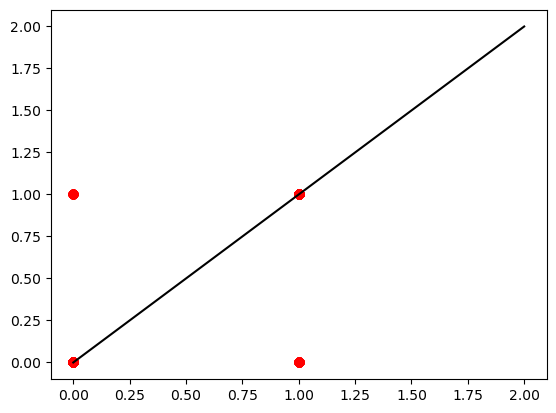

In [29]:
#Neural network using MLPClassifier 

#Going through all of the hidden layers calculated above
# classifier with 3 layers
# max_iter= # of epochs
#1 epoch = combination of one cycle of feed-forward and back propagation phase.
mlp1 = MLPClassifier(hidden_layer_sizes=(62,62), max_iter=2500) #Any nodes greater than 62 were out of bounds for the for loop above
 
# now fit the classifer to the training data
mlp1.fit(X_train, y_train)
# Predictions with classifier
predictions = mlp1.predict(X_test)

plt.plot(y_test, predictions, 'ro')
plt.plot([0, 2], [0, 2],'k')


#confusion matrix to determine the accuracy ( total # of correct predictions / by the total # of all predictions)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
#(precision, recall, f1scores must be > 0.90 to be considered acceptable)

#Confusion matrix tells us the model's prediction performance (false positives and false negatives)
#Precision tells us what proportion of true positives are actuall correct (TP/(TP+FP)
#Recall is what proportion of actual positives are identified correctly (TP/(TP+FN))
#F1 score is the model performance measurment (2*[(precision*recall)/(precision+recall)]) OR = (TP)/[(TP)+(1/2)(FP+FN)]
#Any value above 0.90 is pretty accurate

In [31]:
# here we apply the new model built above to 'new' data

classes = {0:'No Bloom',1:'Bloom'}

# Make a prediction for the 'new' data - new data is randomized, the data I wanted to use did not have all the necessary variables :(
# predict for the below two random observations

bdf=DownloadCSV('RandomBloomData.csv','bdf')

x_new = bdf
x_new_scaled = scaler.transform(x_new)
x_new

Depth_m    Kbrevis  Temp_C  Salinity  NO3   O2   PO4  chl  Si
0       0.1  154393567      22        18    8  230  0.00    2  24
1       0.5  121960274      14        18    8  223  0.00    1  20
2       0.3          0      17         4   14  214  0.00    0   6
3       0.5          0      17         4    3  260  0.00    0  11
4       0.5  172017193      13         3    4  209  0.05    0   5
5       0.5          0      12         0    1  248  0.00    1  16
6       0.0   10254806      24        17    2  257  0.00    0  12
7       0.0   55299351      12        25    6  212  0.00    2  22
8       0.0   64433931      25        21   12  219  0.00    0   4
9       0.5   86821436      23        18    9  258  0.00    1  19
10      0.5          0      17         6    3  256  0.00    0   6
11      0.5   27313593      36         5    1  222  0.00    0  15
12      0.0   18340988      36        34    4  229  0.00    1  19
13      0.0  141136187      12        32   12  255  0.00    2  17
14      0.0   49119246      35        17    7  235  0.00    0  15
15      0.1   52280257      24         3    5  207  0.00    1  24
16      0.2  172528633      37        37    5  225  0.00    2  18
17      0.0   42386429      13         4    5  260  0.00    2  19
18      0.0  130801694      13        24    4  212  0.00    1  18
19      0.5  145709452      30        38    7  193  0.00    0  13

In [32]:
y_predict = mlp1.predict(x_new_scaled)
print(classes[y_predict[0]])
print(classes[y_predict[1]])
print(classes[y_predict[2]])
print(classes[y_predict[3]])
print(classes[y_predict[4]])
print(classes[y_predict[5]])
print(classes[y_predict[6]])
print(classes[y_predict[7]])
print(classes[y_predict[8]])
print(classes[y_predict[9]])
print(classes[y_predict[10]])
print(classes[y_predict[11]])
print(classes[y_predict[12]])
print(classes[y_predict[13]])
print(classes[y_predict[14]])
print(classes[y_predict[15]])
print(classes[y_predict[16]])
print(classes[y_predict[17]])
print(classes[y_predict[18]])
print(classes[y_predict[19]])
#probability that each unknown wine fits into target classes
predictprob=mlp1.predict_proba(x_new_scaled)
Report= pd.DataFrame(predictprob)
Report

#My model is predicting the probability of the unknowns as mostly Blooms (with a 100% certainty). 
#

Bloom
Bloom
No Bloom
No Bloom
Bloom
No Bloom
Bloom
Bloom
Bloom
Bloom
No Bloom
Bloom
Bloom
Bloom
Bloom
Bloom
Bloom
Bloom
Bloom
Bloom


0             1
0   0.000000  1.000000e+00
1   0.000000  1.000000e+00
2   1.000000  1.526756e-07
3   1.000000  1.172825e-10
4   0.000000  1.000000e+00
5   0.998365  1.635015e-03
6   0.000000  1.000000e+00
7   0.000000  1.000000e+00
8   0.000000  1.000000e+00
9   0.000000  1.000000e+00
10  1.000000  4.233953e-11
11  0.000000  1.000000e+00
12  0.000000  1.000000e+00
13  0.000000  1.000000e+00
14  0.000000  1.000000e+00
15  0.000000  1.000000e+00
16  0.000000  1.000000e+00
17  0.000000  1.000000e+00
18  0.000000  1.000000e+00
19  0.000000  1.000000e+00

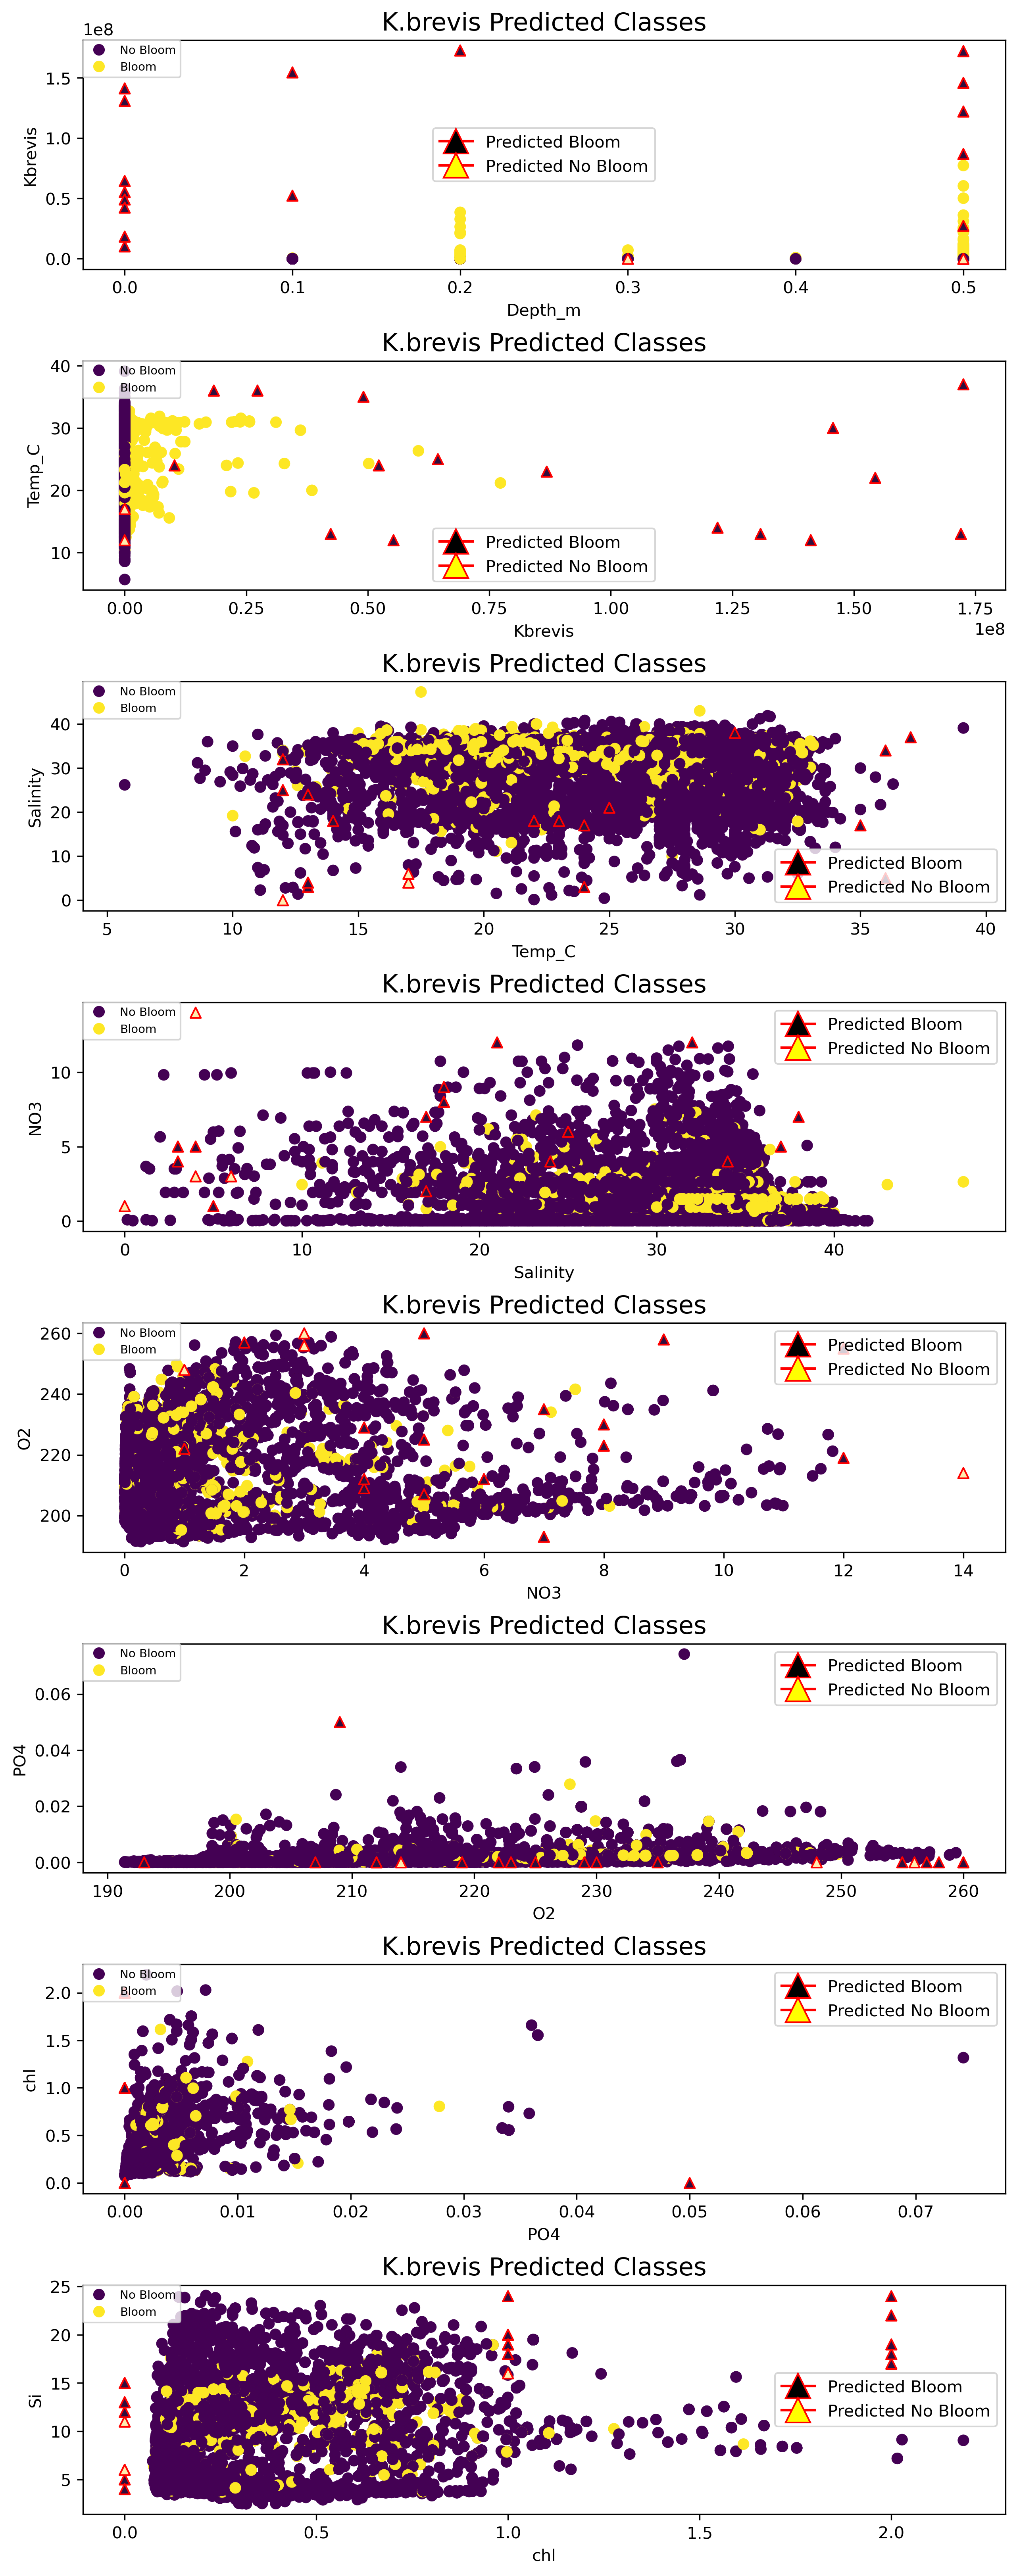

In [34]:
##Need to edit figure
nrows, ncols = 8, 1 #set 4 rows and 2 columns
#custom legend for predict values
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='^', color='red', label='Predicted Bloom',markerfacecolor='black', markersize=15,),
                   Line2D([0], [0], marker='^', color='red', label='Predicted No Bloom',markerfacecolor='yellow', markersize=15,)]

fig2 = plt.figure(figsize = (10,27), dpi = 300)

for i in range(1, 9): #i will iterate from 1 through 9
    ax = fig2.add_subplot(nrows, ncols, i) #add subplot one at a time (#rows and columns, i is the position)
    PltScat=ax.scatter(x.iloc[:,i-1], x.iloc[:,i],c=y) #based on number of the column iloc is index location i-1 (starting point @ 0), i
    Label=label
    ax.legend(PltScat.legend_elements()[0],Label,prop = {'size' : 9})
    ax.set_xlabel(x.columns[i-1])
    ax.set_ylabel(x.columns[i])
    legend=ax.legend(PltScat.legend_elements()[0],Label,prop= {'size' : 7}, loc='upper left',borderaxespad=0)
    ax.add_artist(legend)
    ax.set_title('K.brevis Predicted Classes',size=15)
    ax.scatter(np.array(x_new)[:,i-1], np.array(x_new)[:,i],c=y_predict,cmap='cmo.matter',s = 40,edgecolors='red',marker='^')
    ax.legend(handles=legend_elements)
plt.subplots_adjust(wspace=0.5,hspace=0.4)
plt.show()


#It is difficult to distinguish between the 2 classes.